### MSEplots functions --- adding ensembles of entrainment and detrainment, internal-gravity  waves
keyword arguments for the ensemble size, and h0 range <br>
fixed: "h4ent = mse" would replace mse as doing h4ent += h0offset, rewriting this part 

adding s,h,hs overlay, entrainment xaxis

<br>
Date: 10/29

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import metpy.calc as mpcalc
from metpy.units import units
from metpy.constants import Cp_d,Lv,Rd,g 

In [3]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin() # find minimum
    return (idx)

In [12]:
def thermo_plots(pressure,temperature,mixing_ratio):
    """"
    plots for vertical profiles of temperature, dewpoint, mixing ratio and relative humidity.
    
    Parameters
    ----------
    pressure : array-like
            Atmospheric pressure profile (surface to TOA)
    temperature: array-like
            Atmospheric temperature profile (surface to TOA)
    dewpoint: array-like
            Atmospheric dewpoint profile (surface to TOA)    
    Returns
    -------
    """
    p = pressure*units('mbar')
    q = mixing_ratio*units('kilogram/kilogram')
    T = temperature*units('degC')
    
    Td = mpcalc.dewpoint_from_specific_humidity(q,T,p) # dewpoint 
    Tp = mpcalc.parcel_profile(p,T[0],Td[0]) # parcel
    
    plt.figure(figsize = (12,5))
    
    lev = find_nearest(p.magnitude,100);
    plt.subplot(1,3,1)
    plt.plot(T[:lev],p[:lev],'-ob')
    plt.plot(Td[:lev],p[:lev],'-og')
    plt.plot(Tp[:lev],p[:lev],'-or')
    plt.xlabel('Temperature [C]',fontsize=12)
    plt.ylabel('Pressure [hpa]',fontsize=12)
    plt.gca().invert_yaxis()
    plt.legend(['Temp','Temp_Dew','Temp_Parcel'],loc=1)
    plt.grid()
    
    qs = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(T),p)
    # Relative humidity
    RH = q/qs*100 # Relative humidity

    plt.subplot(1,3,2)
    plt.plot(q[:lev],p[:lev],'-og')
    plt.xlabel('Mixing ratio [kg/kg]',fontsize=12)
    plt.gca().invert_yaxis()
    plt.grid()

    plt.subplot(1,3,3)
    plt.plot(RH[:lev],p[:lev],'-og')
    plt.xlabel('Relative humiduty [%]',fontsize=12)
    plt.gca().invert_yaxis()
    plt.grid()
    
    plt.tight_layout()
    return (plt)

def theta_plots(pressure,temperature,mixing_ratio):
    """
    plots for vertical profiles of potential temperature, equivalent potential temperature, 
    and saturated equivalent potential temperature
    """
    p = pressure*units('mbar')
    T = temperature*units('degC')
    q = mixing_ratio*units('kilogram/kilogram')
    
    lev = find_nearest(p.magnitude,100)
    Td = mpcalc.dewpoint(mpcalc.vapor_pressure(p,q)) # dewpoint 
    theta = mpcalc.potential_temperature(p,T)
    theta_e = mpcalc.equivalent_potential_temperature(p,T,Td)
    theta_es = mpcalc.equivalent_potential_temperature(p,T,T)
       
    plt.figure(figsize=(7,7))
    plt.plot(theta[:lev],p[:lev],'-ok')
    plt.plot(theta_e[:lev],p[:lev],'-ob')
    plt.plot(theta_es[:lev],p[:lev],'-or')
    plt.xlabel('Temperature [K]',fontsize=12)
    plt.ylabel('Pressure [hpa]',fontsize=12)
    plt.gca().invert_yaxis()
    plt.legend(['$\\theta$','$\\theta_e$','$\\theta_{es}$'],loc=1)
    plt.grid()
    return (plt)

def msed_plots(pressure,temperature,mixing_ratio,h0_std=2000,ensemble_size=20,ent_rate=np.arange(0,2,0.05),
               entrain=False):
    """
    plotting the summarized static energy diagram with annotations and thermodynamic parameters
    """
    p  = pressure*units('mbar')
    T  = temperature*units('degC')
    q  = mixing_ratio*units('kilogram/kilogram')
    qs = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(T),p)
    Td = mpcalc.dewpoint(mpcalc.vapor_pressure(p,q)) # dewpoint 
    Tp = mpcalc.parcel_profile(p,T[0],Td[0]).to('degC') # parcel profile

    # Altitude based on the hydrostatic eq.
    altitude = np.zeros((np.size(T)))*units('meter') # surface is 0 meter
    for i in range(np.size(T)):
        altitude[i] = mpcalc.thickness_hydrostatic(p[:i+1],T[:i+1]) # Hypsometric Eq. for height
  
    # Static energy calculations   
    mse = mpcalc.moist_static_energy(altitude,T,q)
    mse_s = mpcalc.moist_static_energy(altitude,T,qs)
    dse = mpcalc.dry_static_energy(altitude,T)

    # Water vapor calculations
    p_PWtop = max(200*units.mbar, min(p) + 1*units.mbar) # integrating until 200mb 
    cwv = mpcalc.precipitable_water(Td,p,top=p_PWtop) # column water vapor [mm]
    cwvs = mpcalc.precipitable_water(T,p,top=p_PWtop) # saturated column water vapor [mm]
    crh = (cwv/cwvs)*100. # column relative humidity [%]

    #================================================
    # plotting MSE vertical profiles
    fig = plt.figure(figsize=[12,8])
    ax = fig.add_axes([0.1,0.1,0.6,0.8])
    ax.plot(dse,p,'-k',linewidth=2)
    ax.plot(mse,p,'-b',linewidth=2)
    ax.plot(mse_s,p,'-r',linewidth=2)
    
    # mse based on different percentages of relative humidity
    qr = np.zeros((9,np.size(qs)))*units('kilogram/kilogram'); mse_r = qr*units('joule/kilogram')# container
    for i in range(9):
        qr[i,:] = qs*0.1*(i+1)
        mse_r[i,:] = mpcalc.moist_static_energy(altitude,T,qr[i,:])

    for i in range(9):
        ax.plot(mse_r[i,:],p[:],'-',color='grey',linewidth=0.7)
        ax.text(mse_r[i,3].magnitude/1000-1,p[3].magnitude,str((i+1)*10))
                
    # drawing LCL and LFC levels
    [lcl_pressure, lcl_temperature] = mpcalc.lcl(p[0], T[0], Td[0])
    lcl_idx = np.argmin(np.abs(p.magnitude - lcl_pressure.magnitude))
    
    [lfc_pressure, lfc_temperature] = mpcalc.lfc(p,T,Td)
    lfc_idx = np.argmin(np.abs(p.magnitude - lfc_pressure.magnitude))
    
    # conserved mse of air parcel arising from 1000 hpa    
    mse_p = np.squeeze(np.ones((1,np.size(T)))*mse[0].magnitude)
    
    # illustration of CAPE
    el_pressure,el_temperature = mpcalc.el(p,T,Td) # equilibrium level
    el_idx = np.argmin(np.abs(p.magnitude - el_pressure.magnitude))
    ELps = [el_pressure.magnitude] # Initialize an array of EL pressures for detrainment profile
    
    [CAPE,CIN] = mpcalc.cape_cin(p[:el_idx],T[:el_idx],Td[:el_idx],Tp[:el_idx])
    
    plt.plot(mse_p,p,color='green',linewidth=2)
    ax.fill_betweenx(p[lcl_idx:el_idx+1],mse_p[lcl_idx:el_idx+1],mse_s[lcl_idx:el_idx+1],interpolate=True
                    ,color='green',alpha='0.3')

    ax.fill_betweenx(p,dse,mse,color='deepskyblue',alpha='0.5')
    ax.set_xlabel('Specific static energies: s, h, hs [kJ kg$^{-1}$]',fontsize=14)
    ax.set_ylabel('Pressure [hpa]',fontsize=14)
    ax.set_xticks([280,300,320,340,360,380])
    ax.set_xlim([280,390])
    ax.set_ylim(1030,150)
    
    if entrain is True:
    # Depict Entraining parcels
    # Parcel mass solves dM/dz = eps*M, solution is M = exp(eps*Z)
    # M=1 at ground without loss of generality
            
    # Distribution of surface parcel h offsets
        H0STDEV = h0_std # J/kg
        h0offsets = np.sort(np.random.normal(0, H0STDEV, ensemble_size))*units('joule/kilogram')
        # Distribution of entrainment rates 
        entrainment_rates = ent_rate /(units('km'))
        
        for h0offset in h0offsets:
            
            h4ent = mse.copy(); h4ent[0] += h0offset;
                
            for eps in entrainment_rates: 

                M = np.exp(eps * (altitude-altitude[0])).to('dimensionless')
                # dM is the mass contribution at each level, with 1 at the origin level. 
                M[0] = 0
                dM = np.gradient(M)

                # parcel mass is a  sum of all the dM's at each level
                # conserved linearly-mixed variables like h are weighted averages 
                hent = np.cumsum(dM*h4ent) / np.cumsum(dM)
    
                # Boolean for positive buoyancy, and its topmost altitude (index) where curve is clippes
                posboy  = (hent > mse_s); posboy[0] = True  # so there is always a detrainment level
        
                ELindex_ent = np.max(np.where(posboy))
                # Plot the curve        
                plt.plot( hent[0:ELindex_ent+2], p[0:ELindex_ent+2], linewidth=0.25, color='g')
                # Keep a list for a histogram plot (detrainment profile)  
                if p[ELindex_ent].magnitude < lfc_pressure.magnitude: # buoyant parcels only
                    ELps.append( p[ELindex_ent].magnitude )
                
        # Plot a crude histogram of parcel detrainment levels
        NBINS = 50
        hist, pbins = np.histogram(ELps[:], bins=NBINS)
        det_per = hist/sum(hist)*100; # percentages of detrainment ensumbles at levels

        ax2 = fig.add_axes([0.705,0.1,0.1,0.8],facecolor=None)
        ax2.barh( pbins[1:], det_per, color='lightgrey',edgecolor='k')
        ax2.set_xlim([0,max(det_per)])
        ax2.set_ylim([1030,150])
        ax2.set_xlabel('Detrainment [%]')
        ax2.grid()
        ax2.set_zorder(2)

        ax.plot( [400,400], [1100,0])
        ax.annotate('Detrainment', xy=(362,320), color='dimgrey')
        ax.annotate('ensemble: ' + str(ensemble_size*len(entrainment_rates)), xy=(364, 340), color='dimgrey')
        ax.annotate('Detrainment', xy=(362,380), color='dimgrey')
        ax.annotate(' scale: 0 - 2 km', xy=(365,400), color='dimgrey')
    
        # Overplots on the mess: undilute parcel and CAPE, etc. 
        ax.plot( (1,1)*mse[0], (1,0)*(p[0]), color='g',linewidth=2)

        # Replot the sounding on top of all that mess
        ax.plot(mse_s , p, color='r', linewidth=1.5) 
        ax.plot(mse , p, color='b', linewidth=1.5) 

        # label LCL and LCF
        ax.plot((mse_s[lcl_idx]+(-2000,2000)*units('joule/kilogram')), lcl_pressure+(0,0)*units('mbar') ,color='orange',linewidth=3)
        ax.plot((mse_s[lfc_idx]+(-2000,2000)*units('joule/kilogram')), lfc_pressure+(0,0)*units('mbar') , color='magenta',linewidth=3)
  
    
    ### Internal waves (100m adiabatic displacements, assumed adiabatic: conserves s, sv, h). 
    #dZ = 100 *mpunits.units.meter
    dp = 1000*units.pascal
    
    # depict displacements at sounding levels nearest these target levels
    targetlevels = [900,800,700,600,500,400,300,200]*units.hPa
    for ilev in targetlevels:
        idx = np.argmin(np.abs(p - ilev))

        # dp: hydrostatic
        rho = (p[idx])/Rd/(T[idx])
        dZ = -dp/rho/g

        # dT: Dry lapse rate dT/dz_dry is -g/Cp
        dT = (-g/Cp_d *dZ).to('kelvin')    
        Tdisp = T[idx].to('kelvin') + dT

        # dhsat
        dqs = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(Tdisp) ,p[idx]+dp) - qs[idx]
        dhs = g*dZ + Cp_d*dT + Lv*dqs

        # Whiskers on the data plots
        ax.plot( (mse_s[idx]+dhs*(-1,1)), p[idx]+dp*(-1,1), linewidth=3, color='r')  
        ax.plot( (dse[idx]    *( 1,1)), p[idx]+dp*(-1,1), linewidth=3, color='k')  
        ax.plot( (mse[idx]    *( 1,1)), p[idx]+dp*(-1,1), linewidth=3, color='b')  

        # annotation to explain it 
        if ilev == 400*ilev.units:
            ax.plot(360*mse_s.units +dhs*(-1,1)/1000, 440*units('mbar')
                     +dp*(-1,1), linewidth=3, color='r')  
            ax.annotate('+/- 10mb', xy=(362,440), fontsize=8)
            ax.annotate(' adiabatic displacement', xy=(362,460), fontsize=8)
    
    # Plot a crude histogram of parcel detrainment levels
    # Text parts
    ax.text(290,pressure[3],'RH (%)',fontsize=11,color='k')
    ax.text(285,200,'CAPE = '+str(np.around(CAPE.magnitude,decimals=2))+' [J/kg]',fontsize=12,color='green')
    ax.text(285,250,'CIN = '+str(np.around(CIN.magnitude,decimals=2))+' [J/kg]',fontsize=12,color='green')
    ax.text(285,300,'LCL = '+str(np.around(lcl_pressure.magnitude,decimals=2))+' [hpa]',fontsize=12,color='darkorange')
    ax.text(285,350,'LFC = '+str(np.around(lfc_pressure.magnitude,decimals=2))+' [hpa]',fontsize=12,color='magenta')
    ax.text(285,400,'CWV = '+str(np.around(cwv.magnitude,decimals=2))+' [mm]',fontsize=12,color='deepskyblue')
    ax.text(285,450,'CRH = '+str(np.around(crh.magnitude,decimals=2))+' [%]',fontsize=12,color='blue')
    ax.legend(['DSE','MSE','SMSE'],fontsize=12,loc=1)
    
    ax.set_zorder(3)
    
    return (ax)

def add_curves_Wyoming(datetime,station,linewidth=1.0):
    """
    overlaying new curves of multiple soundings from Wyoming datasets
    date: using datetime module. ex. datetime(2018,06,06) 
    station: station name. ex. 'MFL' Miami, Florida
    """
    from siphon.simplewebservice.wyoming import WyomingUpperAir

    date = datetime
    station = station
    df = WyomingUpperAir.request_data(date, station)
    pressure = df['pressure'].values
    Temp = df['temperature'].values
    Temp_dew = df['dewpoint'].values
    altitude = df['height'].values
    q = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(Temp_dew*units('degC')),pressure*units('mbar'))
    q = mpcalc.specific_humidity_from_mixing_ratio(q)
    qs = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(Temp*units('degC')),pressure*units('mbar'))
    
    # specific energies
    mse = mpcalc.moist_static_energy(altitude*units('meter'),Temp*units('degC'),q)
    mse_s = mpcalc.moist_static_energy(altitude*units('meter'),Temp*units('degC'),qs)
    dse = mpcalc.dry_static_energy(altitude*units('meter'),Temp*units('degC'))
    # adding curves on the main axes
    ax.plot(dse.magnitude, pressure, 'k', linewidth=linewidth)
    ax.plot(mse.magnitude, pressure, 'b', linewidth=linewidth)
    ax.plot(mse_s.magnitude, pressure, 'r', linewidth=linewidth)

def add_curves(pressure,temperature,mixing_ratio,linewidth=1.0):
    """
    overlaying new curves of multiple soundings from profiles
    """
    p  = pressure*units('mbar')
    T  = temperature*units('degC')
    q  = mixing_ratio*units('kilogram/kilogram')
    qs = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(T),p)
    Td = mpcalc.dewpoint(mpcalc.vapor_pressure(p,q)) # dewpoint 
    Tp = mpcalc.parcel_profile(p,T[0],Td[0]).to('degC') # parcel profile

    # Altitude based on the hydrostatic eq.
    altitude = np.zeros((np.size(T)))*units('meter') # surface is 0 meter
    for i in range(np.size(T)):
        altitude[i] = mpcalc.thickness_hydrostatic(p[:i+1],T[:i+1]) # Hypsometric Eq. for height
  
    # Static energy calculations   
    mse = mpcalc.moist_static_energy(altitude,T,q)
    mse_s = mpcalc.moist_static_energy(altitude,T,qs)
    dse = mpcalc.dry_static_energy(altitude,T)

    ax.plot(dse, p, 'k', linewidth=linewidth)
    ax.plot(mse, p, 'b', linewidth=linewidth)
    ax.plot(mse_s, p, 'r', linewidth=linewidth)

def add_RCEREF(cooling=-1.3,heatflux=116):
    ### Energy is area, draw reference boxes. 
    RCEloc = 260
    ax.set_xlim([250,390])

    ax.plot([RCEloc,RCEloc],[0,1100], linewidth=0.5) ### thin reference line
    ax.annotate('daily RCE', xy=(RCEloc,1045), horizontalalignment='center')

    #### Radiative cooling reference
    ax.fill([RCEloc  , RCEloc -1.3, RCEloc -1.3, RCEloc, RCEloc ],             
            [1000 , 1000    , 200     , 200, 1000],             
            linewidth=1, color='c', alpha=0.9)

    ax.annotate(' cooling'+ str(cooling) + '$K/d$',  xy=(RCEloc-5, 300), color='c')
    ax.annotate('$- 10^7 J m^{-2}$ per day', xy=(RCEloc-5, 330))

    #### Surface flux reference
    ax.fill([RCEloc  , RCEloc +11, RCEloc +11, RCEloc, RCEloc ],             
            [1000 , 1000   , 910    , 910, 1000],             
            linewidth=1, color='orange', alpha=0.5)

    ax.annotate(' heat flux', xy=(RCEloc,890), color='orange')
    ax.annotate(str(heatflux) + '$W m^{-2}$', xy=(RCEloc,940))
    ax.annotate(' for 1 day ='     , xy=(RCEloc,965), fontsize=9)
    ax.annotate('+ $10^7 J m^{-2}$'  , xy=(RCEloc, 990))

In [18]:
from siphon.simplewebservice.wyoming import WyomingUpperAir
# reading data prociding vertical profiles of T, Td, pressure and height
date = datetime(2018, 8, 20, 0)
station = 'MFL'

df = WyomingUpperAir.request_data(date, station)
pressure = df['pressure'].values 
Temp = df['temperature'].values 
Temp_dew = df['dewpoint'].values 
altitude = df['height'].values

from metpy.calc.thermo import *
from metpy.units import units
q = mixing_ratio(saturation_vapor_pressure(Temp_dew*units.degC),pressure*units.mbar)
q = specific_humidity_from_mixing_ratio(q)

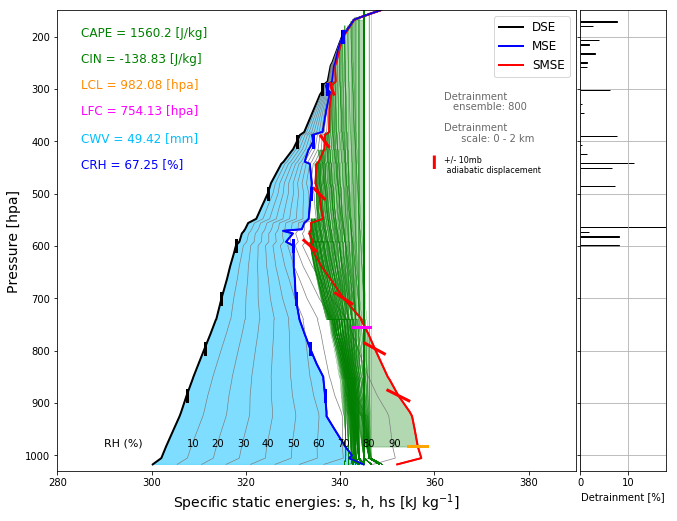

In [19]:
ax = msed_plots(pressure,Temp,q,ent_rate=np.arange(0,2,0.05),entrain=True) # altitude included

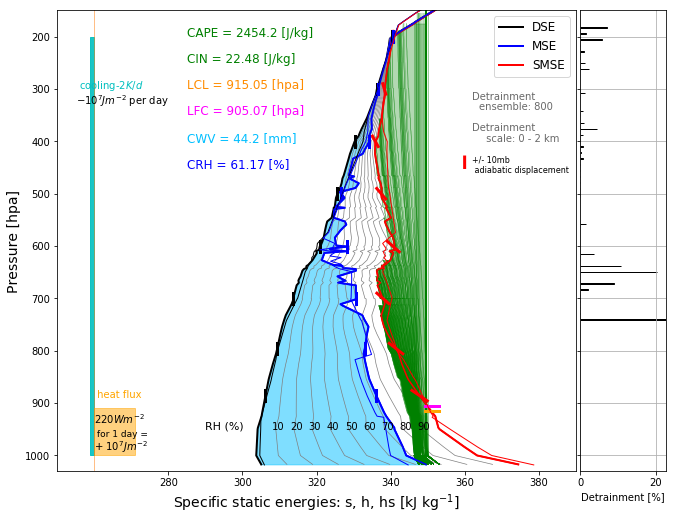

In [12]:
ax = msed_plots(pressure,Temp,q,entrain=True) # altitude included
add_RCEREF(cooling=-2,heatflux=220) # add data-independent info
add_curves_Wyoming(datetime(2018,8,6,0),'MFL') # add curves from Wyoming soundings

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
       1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 ,
       1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95])